In [ ]:
! pip install transformers

In [ ]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import pickle
from tqdm import tqdm
import seaborn as sns
import collections

import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig ,DistilBertTokenizerFast, DistilBertForQuestionAnswering

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import DistilBertModel, DistilBertConfig

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import pickle
import torch.optim as optim

from google.colab import drive 
drive.mount('/content/drive')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cpu')

In [ ]:
class ermQA(torch.utils.data.Dataset):
    def __init__(self, filename):
        with open(f"/content/drive/Shareddrives/NLP/EHReader/processed_data/{filename}.pickle", "rb") as f:
            self.encodings = pickle.load(f)

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
class DistilBERTEncoder(torch.nn.Module):
    def __init__(self, frozen=True):
        super(DistilBERTEncoder, self).__init__()
        self.encoder = DistilBertModel.from_pretrained('distilbert-base-uncased', output_hidden_states = True)
        self.encoder.to(device)
        if frozen:
            self.encoder.requires_grad = False
            self.encoder.eval()

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids, attention_mask = attention_mask)
        embedding = torch.cat([output[1][i] for i in [-1,-2,-3,-4]], dim=-1) # [batch, 512, 3072]

        return embedding
    
    
class SimpleReader(torch.nn.Module):
  
    def __init__(self, in_features=3072, out_features=1):
        super(SimpleReader, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, embeddings):
        # Embedding for the first token ([CLS]) 
        embedding_first_token = torch.squeeze(embeddings[:, 0, :], axis = 1) # [batch, 3072]    
        linear = self.linear(embedding_first_token) # [batch, 1] 
        logit = self.sigmoid(linear)  # [batch, 1]   
        return logit
    

class DeepReader(torch.nn.Module):
    def __init__(self, embed_size, num_heads):
        super(DeepReader, self).__init__()
        
        # Self attention on passage 
        self.passage_key_linear = nn.Linear(embed_size, embed_size)
        self.passage_value_linear = nn.Linear(embed_size, embed_size)
        self.passage_query_linear = nn.Linear(embed_size, embed_size)
        self.passage_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Self attention on question 
        self.question_key_linear = nn.Linear(embed_size, embed_size)
        self.question_value_linear = nn.Linear(embed_size, embed_size)
        self.question_query_linear = nn.Linear(embed_size, embed_size)
        self.question_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Cross attention 
        self.cross_query_linear = nn.Linear(embed_size, embed_size)
        self.cross_key_linear = nn.Linear(embed_size, embed_size)
        self.cross_value_linear = nn.Linear(embed_size, embed_size)
        self.cross_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Feed forward neural network (FFN)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, 2)
        )
        
    
    def forward(self, embeddings, token_split_index):
        passage, question = torch.tensor_split(embeddings, token_split_index, dim=1)

        passage_key = self.passage_key_linear(passage)
        passage_value = self.passage_value_linear(passage)
        passage_query = self.passage_query_linear(passage)
        passage_after_attention, _ = self.passage_attention(query=passage_query, key=passage_key, value=passage_value)

        question_key = self.question_key_linear(question)
        question_value = self.question_value_linear(question)
        question_query = self.question_query_linear(question)
        question_after_attention, _ = self.question_attention(query=question_query, key=question_key, value=question_value)

        cross_query = self.cross_query_linear(passage_after_attention)
        cross_key = self.cross_key_linear(question_after_attention)
        cross_value = self.cross_value_linear(question_after_attention)
        cross_attention_embedding, _ = self.cross_attention(query=cross_query, key=cross_key, value=cross_value)

        ffn_output = self.linear_relu_stack(cross_attention_embedding)
        output = nn.functional.softmax(ffn_output, dim=1)

        return output, passage

    
class EHReader(torch.nn.Module):
    def __init__(self):
        super(EHReader, self).__init__()
        self.encoder = DistilBERTEncoder(frozen=False)
        self.sr = SimpleReader(in_features=3072, out_features=1)
        self.dr = DeepReader(embed_size=3072, num_heads=1)
    
    def forward(self, input_ids, attention_mask):
        embedding = self.encoder(input_ids, attention_mask = attention_mask)
        
        sr_logits = self.sr(embedding)
        
        token_split_index = self.generate_token_split_index(input_ids)
        dr_logits, passage = self.dr(embedding, token_split_index)
        
        return sr_logits, dr_logits, passage
    
    def generate_token_split_index(self, input_ids):
        token_split_index = []
        sep_tokens = (input_ids == 102).nonzero(as_tuple=True)
        used_samples = set()
        for i, index in zip(sep_tokens[0], sep_tokens[1]):
            if i.item() not in used_samples:
                token_split_index.append(index.item())
                used_samples.add(i.item())
        return token_split_index

In [ ]:
TRAIN_BATCH_SIZE = 1
train_dataset = ermQA('medication_qa_train')
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)


VAL_BATCH_SIZE = 1
val_dataset = ermQA('medication_qa_val')
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

In [ ]:
model = EHReader()

# model = torch.load('models/EHReader/m_1_f_e_2_vl_2.9071.model')
# with open('models/EHReader/m_1_f_e_2_vl_2.9071.pickle', 'rb') as f:
#     metadata = pickle.load(f)
    
model.to(device)
metadata = dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.dr.cross_key_linear.weight.requires_grad

True

In [ ]:
model.dr.cross_key_linear.weight

Parameter containing:
tensor([[-0.0047,  0.0040, -0.0071,  ...,  0.0029,  0.0022,  0.0115],
        [ 0.0095, -0.0054,  0.0014,  ..., -0.0152,  0.0094, -0.0104],
        [-0.0121,  0.0176, -0.0076,  ...,  0.0175,  0.0076,  0.0109],
        ...,
        [ 0.0144,  0.0008,  0.0063,  ..., -0.0121, -0.0124,  0.0174],
        [-0.0034,  0.0009, -0.0050,  ..., -0.0077, -0.0112,  0.0144],
        [-0.0039, -0.0105, -0.0080,  ...,  0.0148,  0.0178,  0.0161]],
       requires_grad=True)

In [ ]:
torch.cuda.empty_cache()

NUM_EPOCHS = 20

sr_loss_func = nn.BCELoss()
dr_loss_func = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)

optim = AdamW(model.parameters(), lr=5e-5)

if metadata == {}:
    START_EPOCH = 0
    train_loss = []
    val_loss = []
else:
    START_EPOCH = metadata['epoch'] + 1
    train_loss = metadata['train_loss']
    val_loss = metadata['valid_loss']


# for epoch in range(START_EPOCH, START_EPOCH+NUM_EPOCHS):
for epoch in range(START_EPOCH, START_EPOCH+1):
    
    # Train
    batch_loss = []
    model.train()
    for batch in tqdm(train_loader):
        torch.cuda.empty_cache()
        
        # Forward 
        input_ids = torch.tensor(batch['input_ids']).to(device)
        attention_mask = torch.tensor(batch['attention_mask']).to(device)
        sr_out, dr_out, passage_embedding = model(input_ids, attention_mask)

        # Calculate loss
        answerability = (batch['start_positions'] < batch['end_positions']).view(-1, 1).float().to(device)
        sr_loss = sr_loss_func(sr_out, answerability)

        target = torch.zeros(tuple(passage_embedding.shape[0:2]) + (2, )).to(device)
        start_pos = batch['start_positions'][0].item()
        end_pos = batch['end_positions'][0].item()
        target[0, start_pos, 0] = 1
        target[0, end_pos, 1] = 1

        dr_loss = dr_loss_func(dr_out, target)
        
        total_loss = .5 * sr_loss + .5 * dr_loss

        # Calculate loss and backward
        batch_loss.append(total_loss.item())
        optim.zero_grad()
        total_loss.backward()
        optim.step()

        break 

    train_loss.append(np.mean(batch_loss))
 
        
    # Validation
    model.eval()
    batch_loss = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            torch.cuda.empty_cache()

            # Forward 
            input_ids = torch.tensor(batch['input_ids']).to(device)
            attention_mask = torch.tensor(batch['attention_mask']).to(device)
            sr_out, dr_out, passage_embedding = model(input_ids, attention_mask)

            # Calculate loss
            answerability = (batch['start_positions'] < batch['end_positions']).view(-1, 1).float().to(device)
            sr_loss = sr_loss_func(sr_out, answerability)

            target = torch.zeros(tuple(passage_embedding.shape[0:2]) + (2, )).to(device)
            start_pos = batch['start_positions'][0].item()
            end_pos = batch['end_positions'][0].item()
            target[0, start_pos, 0] = 1
            target[0, end_pos, 1] = 1

            dr_loss = dr_loss_func(dr_out, target)

            total_loss = .5 * sr_loss + .5 * dr_loss
            batch_loss.append(total_loss.item())

    val_loss.append(np.mean(batch_loss))
    
    print(f'Epoch: {epoch}, train_loss: {train_loss[-1]}, val_loss: {val_loss[-1]}')
    
    model_name = f'models/EHReader/m_1_uf_e_{len(val_loss)}_vl_{round(val_loss[-1], 4)}'
    metadata = {
        'epoch': epoch,
        'train_loss': train_loss,
        'valid_loss': val_loss
    }
  
    # Early Stopping
    if len(val_loss) > 3:
        if val_loss[-1] > val_loss[-2] > val_loss[-3]:
            torch.save(model, f'/content/drive/Shareddrives/NLP/EHReader/model/{model_name}.model')
            
            with open(f'/content/drive/Shareddrives/NLP/EHReader/model/{model_name}_metadata.pickle', 'wb') as f:
                pickle.dump(metadata, f)
            break
            
    # Check point
    torch.save(model, f'/content/drive/Shareddrives/NLP/EHReader/model/{model_name}.model') 

    with open(f'/content/drive/Shareddrives/NLP/EHReader/model/{model_name}_metadata.pickle', 'wb') as f:
        pickle.dump(metadata, f)

NameError: ignored

# Inference

In [ ]:
def compute_exact_match(prediction, truth):
    exact_match = 0
    for pred, tru in zip(prediction, truth):
        if pred == tru:
            exact_match += 1
    return exact_match / len(prediction)


def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))


def compute_tav_fast(start_logits, end_logits):
    start_probs, end_probs = (torch.softmax(start_logits, dim=0), torch.softmax(end_logits, dim=0))
    n = len(start_logits)
    s_null = start_probs[0] + end_probs[0]
    s_has = 0
    best_span = (0, 0)
    high_start_idx = 1
  
    for i in range(1, n):
        if start_probs[i] > start_probs[high_start_idx]:
            high_start_idx = i
        if start_probs[high_start_idx] + end_probs[i] > s_has:
            s_has = start_probs[high_start_idx] + end_probs[i]
            best_span = (high_start_idx, i)
            
    s_diff = s_null - s_has
    return s_diff.item(), best_span


def compute_rv(sr_logit, dr_logit):
    
    s_ext = (1-2*sr_logit.item())
    
    start_logits, end_logits = dr_logit[:, 0], dr_logit[:, 1]
    s_diff, best_span = compute_tav_fast(start_logits, end_logits)
    
    v = .5 * s_diff + .5 * s_ext
    return v, best_span

def compute_f1(prediction, truth, input_id_list):
    
    f1_scores = []
    
    for i, (pred, gold) in enumerate(zip(prediction, truth)):
        
        if pred == gold:
            f1_scores.append(1)
            
        else:
            pred_tokens = input_id_list[i-1][pred[0]: pred[1]+1]
            gold_tokens = input_id_list[i-1][gold[0]: gold[1]+1]

            total_overlap = len(set(pred_tokens).intersection(set(gold_tokens)))
            total_tru = len(gold_tokens)
            total_pred = len(pred_tokens)

            if len(pred_tokens) == 0 or len(gold_tokens) == 0:
                f1_scores.append(int(pred_tokens == gold_tokens))
            elif total_overlap == 0:
                f1_scores.append(0)
            else:
                prec = total_overlap / total_pred
                rec = total_overlap / total_tru
                f1_scores.append(2 * (prec * rec) / (prec + rec))
    
    return np.mean(f1_scores)

In [ ]:
def generate_predictions(model, data_loader, split):
    truths = []
    
    # Greedy
    spans_greedy = []
    
    # RV
    s_diffs = []
    spans_rv = []
    
    input_id_list = []
    
    model.eval()
    for batch in tqdm(data_loader):
        
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # Truth Span
            for i, j, k in zip(batch['start_positions'], batch['end_positions'], batch['input_ids']):
                truths.append((i.item(), j.item()))
                input_id_list.append(k.tolist())
        
            # Predictions
            input_ids = torch.tensor(batch['input_ids']).to(device)
            attention_mask = torch.tensor(batch['attention_mask']).to(device)
            sr_out, dr_out, _ = model(input_ids, attention_mask)
            
            # Greedy
            for i in dr_out:
                start, end = torch.argmax(i[:, 0], dim=0), torch.argmax(i[:, 1], dim=0)
                spans_greedy.append((start.item(), end.item()))
            
            # RV
            for i, j in zip(sr_out, dr_out):
                s_diff, span = compute_rv(i, j)
                s_diffs.append(s_diff)
                spans_rv.append(span)
    
    predictions_metadata = {
        'truth': truths,
        'spans_greedy': spans_greedy,
        's_diffs': s_diffs,
        'spans_rv': spans_rv,
        'input_id_list': input_id_list
    }
    with open(f'predictions/EHReader/unfrozen_medication_{split}.pickle', 'wb') as f:
        pickle.dump(predictions_metadata, f)
            
    return predictions_metadata


def evaluate_predictions(predictions_metadata, rv=False, threshold=-0.98, print_info=False):
    if not rv:
        spans_pred = predictions_metadata['spans_greedy']
    else:
        spans_pred = []
        for s_diff, span_rv in zip(predictions_metadata['s_diffs'], predictions_metadata['spans_rv']):
            if s_diff < threshold:
                spans_pred.append(span_rv)
            else:
                spans_pred.append((0, 0))
                
    em = compute_exact_match(spans_pred, predictions_metadata['truth'])
    f1 = compute_f1(spans_pred,  predictions_metadata['truth'], predictions_metadata['input_id_list'])
    
    if print_info:
        print(f'EM: {round(em*100, 1)}, F1: {round(f1*100, 1)}')
        
    return em, f1

In [ ]:
TEST_BATCH_SIZE = 1
test_dataset = ermQA('medication_qa_test')
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

train_dataset = ermQA('medication_qa_train')
train_loader = DataLoader(train_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

model = torch.load('models/EHReader/m_1_f_e_1_vl_2.8547.model')
with open('models/EHReader/m_1_f_e_1_vl_2.8547_metadata.pickle', 'rb') as f:
    metadata = pickle.load(f)

In [ ]:
test_predictions_metadata = generate_predictions(model, test_loader, 'test')

  0%|          | 0/12096 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 53%|█████▎    | 6362/12096 [5:00:09<4:28:08,  2.81s/it]

In [ ]:
em, f1 = evaluate_predictions(test_predictions_metadata, rv=False, print_info=True)

EM: 50.0, F1: 50.0


In [ ]:
em, f1 = evaluate_predictions(test_predictions_metadata, rv=True, threshold=-0.1, print_info=True)

EM: 0.0, F1: 0.3


In [ ]:
em_list = []
thresholds = []
for threshold in np.arange(-1, 1, .01):
    em, f1 = evaluate_predictions(test_predictions_metadata, rv=True, threshold=threshold, print_info=False)
    em_list.append(em)
    thresholds.append(threshold)

0.5000000000000013
EM: 50.0, F1: 50.0


(0.5, 0.5)

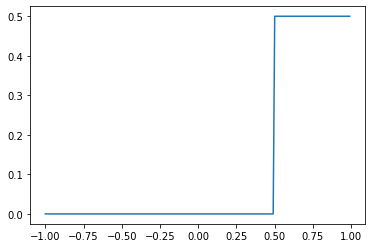

In [ ]:
sns.lineplot(x=thresholds, y=em_list)
max_index = em_list.index(max(em_list))
threshold = thresholds[max_index]
print(threshold)
evaluate_predictions(test_predictions_metadata, rv=True, threshold=threshold, print_info=True)

In [ ]:
train_predictions_metadata = generate_predictions(model, train_loader, 'train')

In [ ]:
em, f1 = evaluate_predictions(train_predictions_metadata, rv=False, print_info=True)

In [ ]:
em_list = []
thresholds = []
for threshold in np.arange(-1, 1, .01):
    em, f1 = evaluate_predictions(train_predictions_metadata, rv=True, threshold=threshold, print_info=False)
    em_list.append(em)
    thresholds.append(threshold)

In [ ]:
sns.lineplot(x=thresholds, y=em_list)
max_index = em_list.index(max(em_list))
threshold = thresholds[max_index]
print(threshold)
evaluate_predictions(train_predictions_metadata, rv=True, threshold=threshold, print_info=True)